### A Gaussian Process Visualization Project from **Principles of Large-Scale Machine Learning — Fall 2022** 
### Skeleton provided by Prof. De Sa, implemented by Toni Liu 
### Nov 25 2022 

In [1]:
import os
import math
import pickle
import numpy as np
import scipy.special
import mnist
from tqdm import tqdm
from matplotlib import pyplot
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import torch
from IPython import display


In [102]:
 torch.get_default_dtype()

torch.float32

In [2]:
#################
### helper functions
#################

# compute the cumulative distribution function of a standard Gaussian random variable
def gaussian_cdf(u):
    return 0.5*(1.0 + torch.special.erf(u/math.sqrt(2.0)))

# compute the probability density function of a standard Gaussian random variable
def gaussian_pdf(u):
    return torch.exp(-u**2/2.0)/math.sqrt(2.0*math.pi)

# produce an animation of the predictions made by the Gaussian process in the course of 1-d Bayesian optimization
#
# objective     objective function
# acq           acquisition function
# gamma         gamma to use for RBF hyper-hyperparameter
# sigma2_noise  additive Gaussian noise parameter for Gaussian Process
# Ys            vector of objective values for all points searched (size: num_iters)
# Xs            matrix of all points searched (size: d x num_iters)
# xs_eval       torch vector of xs at which to evaluate the mean and variance of the prediction at each step of the algorithm
# filename      path at which to store .mp4 output file
def animate_predictions(objective, acq, gamma, sigma2_noise, Ys, Xs, xs_eval, filename):
    mean_eval = []
    variance_eval = []
    acq_eval = []
    acq_Xnext = []
    for it in range(len(Ys)):
        print("rendering frame %i" % it)
        Xsi = Xs[:, 0:(it+1)]
        Ysi = Ys[0:(it+1)]
        ybest = Ysi.min()
        gp_pred = gp_prediction(Xsi, Ysi, gamma, sigma2_noise)
        pred_means = []
        pred_variances = []
        pred_acqs = []
        for x_eval in xs_eval:
            XE = x_eval.reshape(1)
            (pred_mean, pred_variance) = gp_pred(XE)
            pred_means.append(float(pred_mean))
            pred_variances.append(float(pred_variance))
            pred_acqs.append(float(acq(ybest, pred_mean, math.sqrt(pred_variance))))
        mean_eval.append(torch.Tensor(pred_means))
        variance_eval.append(torch.Tensor(pred_variances))
        acq_eval.append(torch.Tensor(pred_acqs))
        if it + 1 != len(Ys):
            XE = Xs[0,it+1].reshape(1)
            (pred_mean, pred_variance) = gp_pred(XE)
            acq_Xnext.append(float(acq(ybest, pred_mean, math.sqrt(pred_variance))))

    fig = pyplot.figure()
    fig.tight_layout()
    ax = fig.gca()
    ax2 = ax.twinx()

    def animate(i):
        ax.clear()
        ax2.clear()
        ax.set_xlabel("parameter")
        ax.set_ylabel("objective")
        ax2.set_ylabel("acquisiton function")
        ax.set_title(f"Bayes Opt After {(i+1)} Steps")
        l1 = ax.fill_between(xs_eval, mean_eval[i] + 2.0*torch.sqrt(variance_eval[i]), mean_eval[i] - 2.0*torch.sqrt(variance_eval[i]), 
                             color="lightcyan", label = r"2$\sigma$ interval")
        l2, = ax.plot(xs_eval, [objective(x.reshape(1)) for x in xs_eval],
                             color = "blue", label = "ground truth")
        l3, = ax.plot(xs_eval, mean_eval[i], 
                             color="r", label = r"$\mu$")
        l4 = ax.scatter(Xs[0,0:(i+1)], Ys[0:(i+1)])
        l5, = ax2.plot(xs_eval, acq_eval[i], 
                             color="g", ls=":", label = "acquisition fxn")
        ax.legend(loc="upper right")
        if i + 1 == len(Ys):
            return l1, l2, l3, l4, l5
        else:
            l6 = ax2.scatter([Xs[0,i+1]], [acq_Xnext[i]], color="g")
            return l1, l2, l3, l4, l5, l6


    ani = animation.FuncAnimation(fig, animate, frames=range(len(Ys)), interval=600, repeat_delay=1000)
    video = ani.to_html5_video()
    html = display.HTML(video)
    display.display(html)         # embed the HTML code in Jupyter Notebook
    plt.close()                   # avoid plotting a spare static plot
    ani.save(filename)
    


RBF kernel:
$$
K(\vec{x}, \vec{z}) = exp \, (-\gamma ||\vec{x}-\vec{z}||^2)
$$

In [92]:
def rbf_kernel_matrix(X_tensor, Z_tensor, 𝛾):
    """
    General function to calculate k
    ernel matrix AND kernel vectors.
    Since point of query x* may be used as arguement, 
    this function must be implemented in tensor
    
    inputs: 
        X_array: points at which to compute the kernel (tensor: d x m)
        Z_array: other points at which to compute the kernel (size: d x n)
        𝛾: 𝛾 parameter for the RBF kernel
    output: 
        Σ: (m x n), where Σ[i,j] = K(X_array[:,i], Z_array[:,j])
        
    """
    diff_mat = X_tensor.transpose(0,1).unsqueeze(1)-Z_tensor.transpose(0,1)
    norm_mat = torch.norm(diff_mat, dim=-1, p=2)
    # print(norm_mat)
    rbf_mat = torch.exp(-𝛾 * norm_mat**2)
    return(rbf_mat)
    

Bayesian prediction with RBF gaussian prior: <br>
Given kernel matrix of all observed points $\Sigma$, and new point of query $x_{*}$:
$$
\begin{align}
\\ mean(x_{*})& = \vec{k_{*}}^T \, (\Sigma+\sigma^2 I)^{-1} \vec{y}
\\ var(x_{*})& = K(x_{*},x_{*}) + \sigma^2 - \vec{k_{*}}^T \, (\Sigma+\sigma^2 I)^{-1}\vec{k_{*}}
\\ & = 1 + \sigma^2 - \vec{k_{*}}^T \, (\Sigma+\sigma^2 I)^{-1}\vec{k_{*}}
\end{align}
$$


where 
kernel covariance matrix
$$
\begin{align}
\\ \Sigma &= \begin{pmatrix}
K_{1,1} & K_{1,2} & \cdots & K_{1,D} \\
\vdots  & \vdots  & \ddots & \vdots  \\
K_{D,1} & K_{D,2} & \cdots & K_{D,D} 
\end{pmatrix}
\\ &= \text{rbf_kernel_matrix(X_array(d x D), X_array(d x D))} \\ &= \text{size(D x D)}
\end{align}
$$

kernel vector of query point
$$
\begin{align}
\\ \vec{k_{*}} &= [K(x_{1},x_{*}),K(x_{2},x_{*}) \cdots K(x_{D},x_{*})]^T 
\\ &= \text{rbf_kernel_matrix(X_array(d x D), x*(d x 1))} 
\\ &= \text{size(D x 1)}
\end{align}
$$

and the corresponding observed vector
$$
\vec{y} = [y_{1},y_{2}, ... , y_{D}]^T
$$

In [93]:
def gp_prediction(Xs, Ys, 𝛾, 𝜎2):
    """
    inputs: 
        Xs: points at which to compute the kernel (size: d x D)
        Ys: observed values at these points (size: D)
        𝛾: 𝛾 parameter for the RBF kernel
        𝜎2: additive noise to model uncertainty of measurements on the same points,
 
 and discontinuity between points
        output:
            function: prediction_mean_and_variance(Xtest)
                input: point to test, Xtest: (size: d)
                output: (mean, variance) tuple
    """
    # calculation shared among predictions
    # print(len(Xs))
    d,D = Xs.shape
    Σ = rbf_kernel_matrix(Xs, Xs, 𝛾)
    Σ_additive_noise = Σ + 𝜎2 * torch.eye(D)
    Σ_additive_noise_inverted = torch.linalg.inv(Σ_additive_noise)
    
    # print(Σ_additive_noise_inverted.shape)
    # print(Xs.shape)
    # print(Ys.shape)
    
    def prediction_mean_and_variance(Xtest):
        k_vec = rbf_kernel_matrix(Xs, Xtest.view(-1,1), 𝛾)
        
        shared_factor = torch.mm(k_vec.mT, Σ_additive_noise_inverted).squeeze(dim=0)
        mean = torch.dot(shared_factor, Ys)
        
        
        # mean = torch.mm(shared_factor, Ys)
        var = 1 + 𝜎2 - torch.dot(shared_factor, k_vec.squeeze(dim=-1))
        # var = torch.tensor(0)
        # return scalars
        return (mean.reshape(()), var.reshape(())) 

    return prediction_mean_and_variance


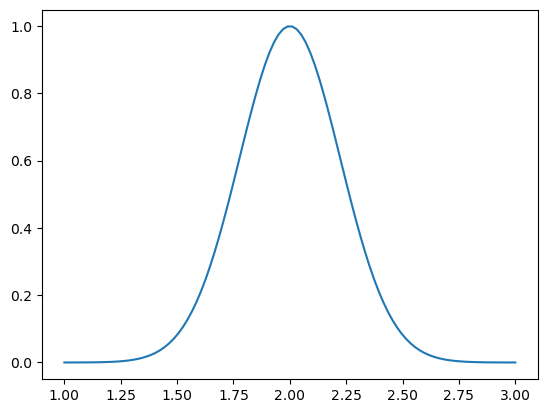

In [112]:
Xs = torch.tensor([[1.],[2.],[3.]]).T
Ys = torch.tensor([0.,1.,0.])
# Xs = torch.tensor([[2.]]).T
# Ys = torch.tensor([2.])
prediction_mean_and_variance = gp_prediction(Xs, Ys, 𝛾=10, 𝜎2=0.)
x_preds = np.linspace(1,3,100)
y_preds = []
for x in x_preds:
    Xtest = torch.tensor(x).float()
    # print(Xtest.dtype)
    # print(Xtest.shape)
    mean, var = prediction_mean_and_variance(Xtest)
    y_preds += [mean]
plt.plot(x_preds,y_preds)

$$
a_{PI}(y_{best},\mu, \sigma) = - \Phi \left(\frac{y_{best}-\mu}{\sigma}\right)
$$

In [95]:
def pi_acquisition(Ybest, mean, stdev):
    """
    Compute the probability of improvement (PI) acquisition function
    This objective only encourages improvements, regardless of magnitude. 
    It can easily get stuck in local optima
    
    input: 
        Ybest: best value observed
        mean: mean of bayesian prediction
        stdev: std of bayesian prediction
    output: 
        negated probability of improvement
    """
    u = (Ybest - mean) / stdev
    return(- gaussian_cdf(u))

Expected improvement addresses this issue by maximizing the expected amount of improvement, if there is any:
$$
a_{EI}(y_{best},\mu, \sigma) = \mathbb{E}[min(f_{*}-y_{best},0)] 
$$

In [96]:
def ei_acquisition(Ybest, mean, stdev):
    """
    input: 
        Ybest: best value observed
        mean: mean of bayesian prediction
        stdev: std of bayesian prediction
    output: 
        EI acquisition objective
    """
    u = (Ybest - mean) / stdev
    return(-(gaussian_pdf(u) + u * gaussian_cdf(u)) * stdev)

lower confidence bound: allows one to customize exploration/exploitation trade-off.

In [97]:
def lcb_acquisition(𝜅):
    def A_lcb(Ybest, mean, stdev):
        return(mean - 𝜅*stdev)
    return A_lcb

In [98]:
# gradient descent to do the inner optimization step of Bayesian optimization
#
# objective     the objective function to minimize, as a function that takes a torch tensor and returns an expression
# x0            initial value to assign to variable (torch tensor)
# alpha         learning rate/step size
# num_iters     number of iterations of gradient descent
#
# returns     (obj_min, x_min), where
#       obj_min     the value of the objective after running iterations of gradient descent
#       x_min       the value of x after running iterations of gradient descent
def gradient_descent(objective, x0, gd_rate, num_iters):
    x = x0.detach().clone()  # create a fresh copy of x0
    x.requires_grad = True   # make it a target for differentiation
    optimizer = torch.optim.SGD([x], gd_rate)
    for it in range(num_iters):
        optimizer.zero_grad()
        f = objective(x)
        f.backward()
        optimizer.step()
    x.requires_grad = False  # make x no longer require gradients
    return (float(f.item()), x)

# a one-dimensional test objective function on which to run Bayesian optimization
def test_objective(x):
    assert isinstance(x, torch.Tensor)
    assert x.shape == (1,)
    x = x.item() # convert to a python float
    return (math.cos(8.0*x) - 0.3 + (x-0.5)**2)

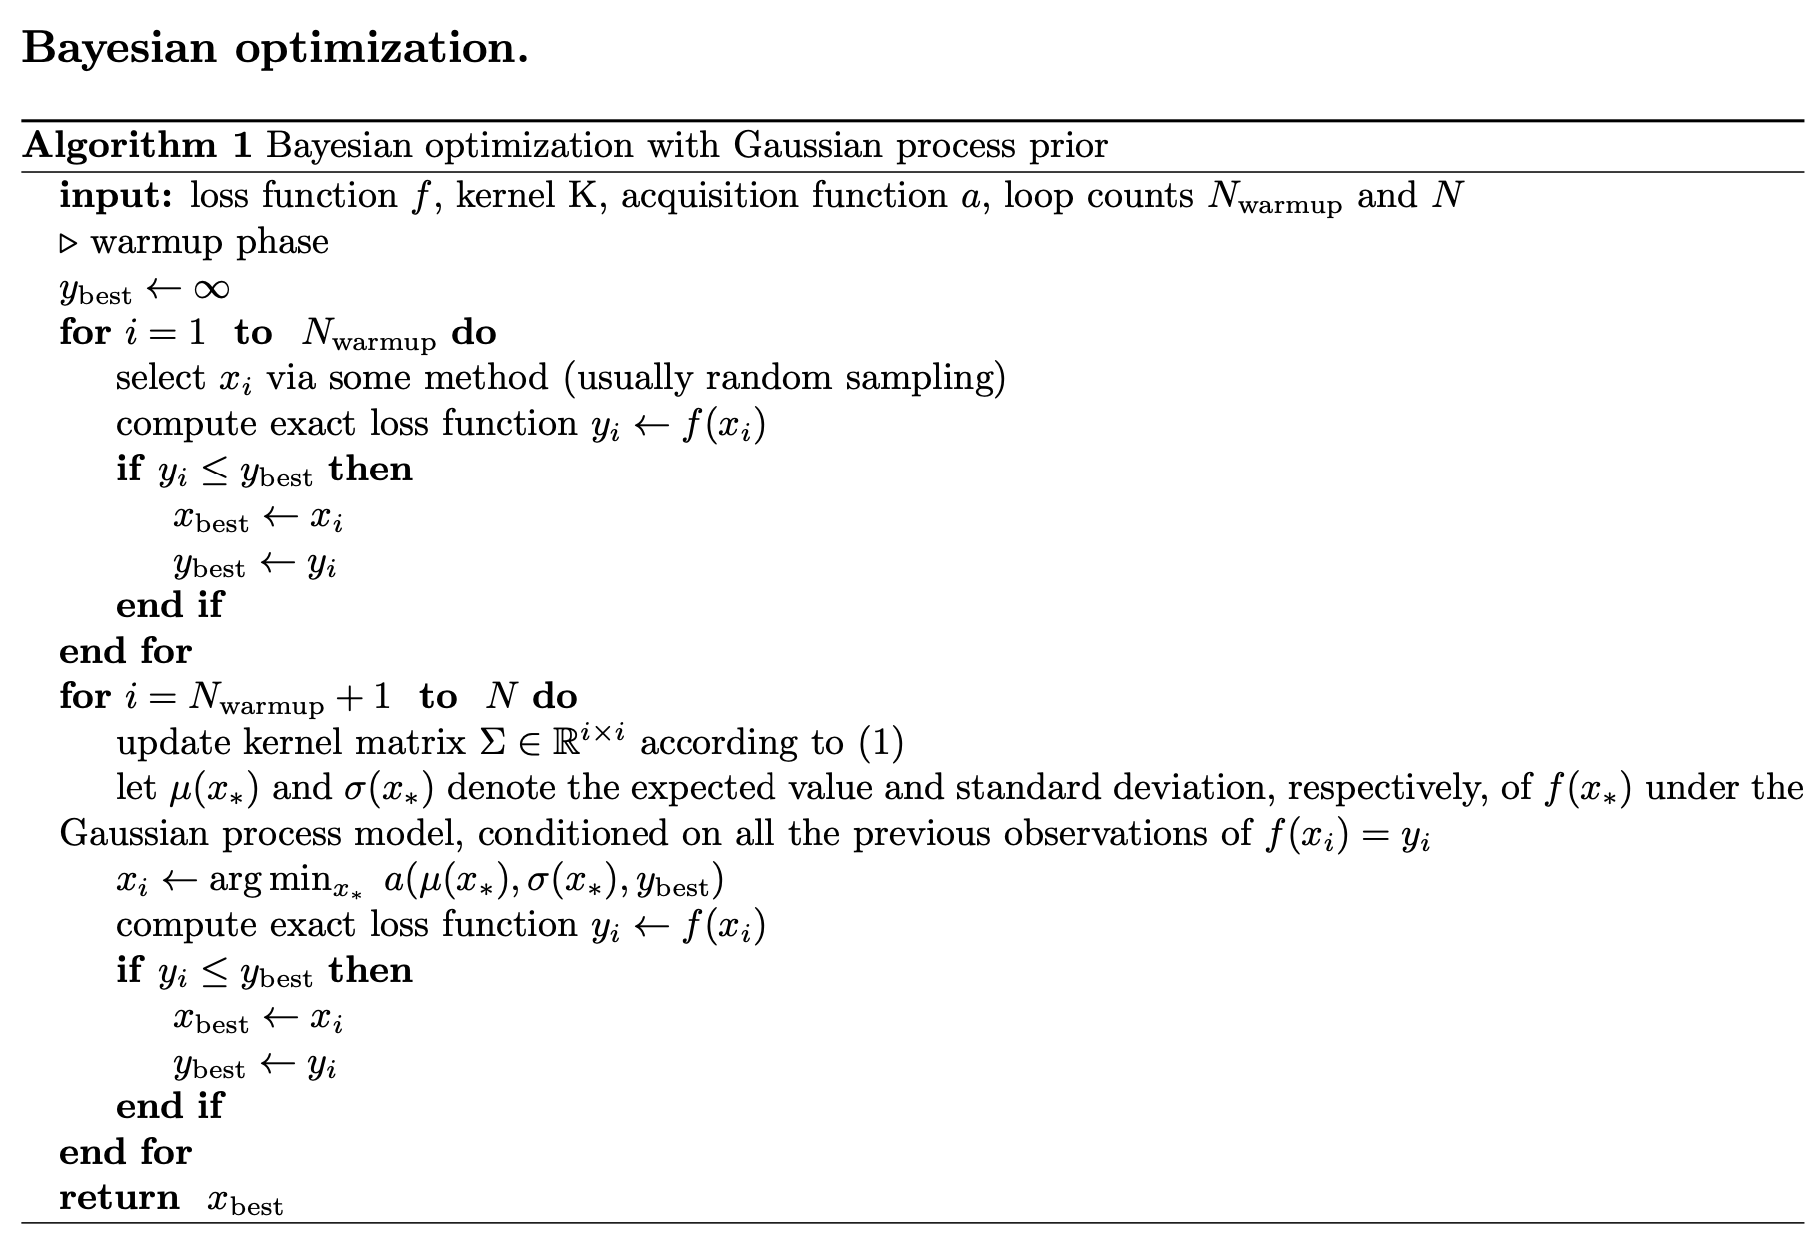

In [99]:
# Toni's 

# run Bayesian optimization to minimize an objective
#
# objective     objective function to minimize; tensor -> python float scalar
# d             dimension to optimize over
# gamma         gamma to use for RBF hyper-hyperparameter
# sigma2_noise  additive Gaussian noise parameter for Gaussian Process
# aqst_func     acquisition function to use (e.g. ei_acquisition)
# random_x      function that returns a random sample of the parameter we're optimizing over (a torch tensor, e.g. for use in warmup)
# gd_nruns      number of random initializations we should use for gradient descent for the inner optimization step
# gd_rate       learning rate for gradient descent
# gd_niters     number of iterations for gradient descent
# n_warmup      number of initial warmup evaluations of the objective to use
# num_iters     number of outer iterations of Bayes optimization to run (including warmup)
#
# returns       tuple of (y_best, x_best, Ys, Xs), where
#   y_best          objective value of best point found
#   x_best          best point found
#   Ys              vector of objective values for all points searched (size: num_iters)
#   Xs              matrix of all points searched (size: d x num_iters)
def bayes_opt(objective, d, 𝛾, 𝜎2, aqst_func, random_x, gd_rate, gd_niters, n_warmup, num_iters):
    y_best = np.inf
    Ys = np.empty((0))
    Xs = np.empty((d,0))
    for i in range(num_iters):
        
        ### warm-up: randomly draw x
        if i < n_warmup:
            x_new = random_x()
            y_new = objective(x_new)
                
        ### after warm-up: draw x that minimizes acquisition function
        else:
            prediction_mean_and_variance = gp_prediction(torch.tensor(Xs), torch.tensor(Ys), 𝛾, 𝜎2) 
            
            def GD_objective(x):
                """
                    input: x, new point to query
                    output: acquistion value
                """
                mean, var = prediction_mean_and_variance(x)
                return aqst_func(y_best, mean, torch.sqrt(var))
            
            ### use GD to minimize acquisition function
            x0 = random_x()
            aqst_min, x_new = gradient_descent(GD_objective, x0, gd_rate, gd_niters)
            y_new = objective(x_new)
            
        if y_new < y_best:
            y_best = y_new
            x_best = x_new

        Ys = np.append(Ys,y_new)
        Xs = np.append(Xs,x_new.unsqueeze(dim=0),axis=1)
        
    return (y_best, x_best, torch.tensor(Ys), torch.tensor(Xs))
            
    
        
        

### First time running has tensor shape warnings: 
The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor.

In [100]:
def test_random_x():
    return 1.5 * torch.rand(1) - 0.25

gamma=10
self_noise=0.001
aqst_func=ei_acquisition
itr = 15

(y_best, x_best, Ys, Xs) = bayes_opt(test_objective, d=1, 𝛾=gamma, 𝜎2=self_noise, aqst_func=aqst_func, random_x=test_random_x, gd_rate=0.001, gd_niters=20, n_warmup=3, num_iters=itr)

print(y_best)
print(x_best)
print(f"Ys {Ys}")
print(f"Xs {Xs}")




-1.1416540274802598
tensor([0.4637])
Ys tensor([-0.5753,  0.2930, -0.9100, -1.1417, -0.2037, -0.1119, -0.4852, -0.9996,
        -0.3278, -0.8618,  0.7335,  0.2676,  0.1894,  0.7571,  0.4180],
       dtype=torch.float64)
Xs tensor([[ 0.2401,  0.9291,  0.5070,  0.4637,  1.0012, -0.2429,  1.0446,  0.4922,
          0.5847,  0.5145,  0.7541,  0.9330,  0.6498,  0.8243, -0.1607]],
       dtype=torch.float64)


### Animation error: mean and variance curve seems to be accumulating throught frames

In [101]:
Xs_plot = torch.linspace(-0.5, 1.5, steps=256)
animate_predictions(test_objective, aqst_func, gamma, self_noise, Ys, Xs, Xs_plot, f"bayes_opt_ei_γ_{gamma}_𝜎2_{self_noise}.mp4")


rendering frame 0
rendering frame 1
rendering frame 2
rendering frame 3
rendering frame 4
rendering frame 5
rendering frame 6
rendering frame 7
rendering frame 8
rendering frame 9
rendering frame 10
rendering frame 11
rendering frame 12
rendering frame 13
rendering frame 14
